In [1]:
import numpy as np
from scipy.optimize import curve_fit
import scipy as sp
from scipy.signal import find_peaks
from matplotlib import pyplot as plt
import pandas as pd
import os

In [2]:
plt.style.use(['science', 'notebook', 'grid'])
mm, um, nm = (10**(-3), 10**(-6), 10**(-9))

def sci_notation(number: float, n_decimals: int = 2) -> str:
    sci_notation = f"{number:e}"
    decimal_part, exponent = sci_notation.split("e")
    decimal_part = float(decimal_part)
    exponent = int(exponent)

    if decimal_part == 1.0:
        return f"$10^{exponent}$"
    else:
        return f"{decimal_part:.{n_decimals}f}$\cdot 10^{exponent}$"    

# Experiment

### calculate voltage on the resistor as a function of angle $\theta$

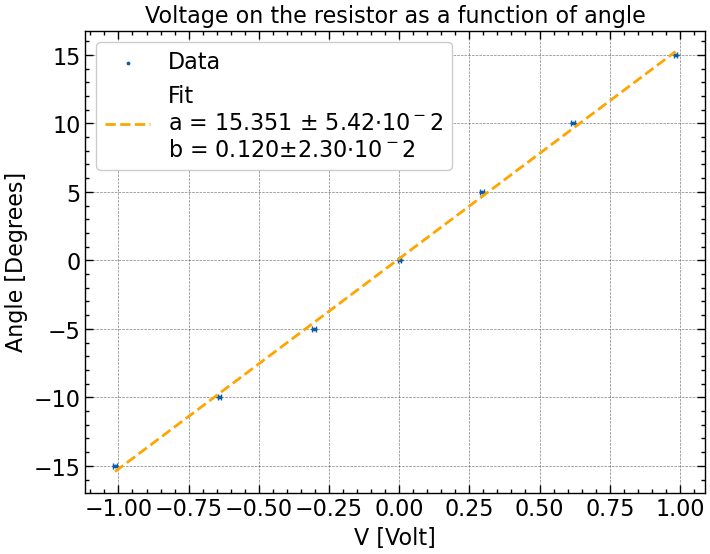

In [3]:
dir = 'Data\\calibration 2'

v_R_data = pd.DataFrame(columns=['angle', 'mean voltage', 'voltage std'], dtype='float64')

with os.scandir(dir) as it:
        for file in it:
            point = pd.read_csv(file, sep='\t', skiprows=6)
            row = {'angle':int(file.name.split(".")[0]), 'mean voltage':point['Ch1[V]'].mean(), 
                   'voltage std':point['Ch1[V]'].std()}
            v_R_data = pd.concat([v_R_data, pd.Series(row, dtype='float64').to_frame().T], ignore_index=True)
v_R_data = v_R_data.sort_values('angle')

def fit_V_R(V, a, c):
      return a*V + c

fit_v = np.linspace(v_R_data['mean voltage'].min(), v_R_data['mean voltage'].max(), 100, endpoint=True)
popt, pcov = curve_fit(fit_V_R, v_R_data['mean voltage'], v_R_data['angle'])
fit_theta = fit_V_R(fit_v, *popt)


plt.figure()
plt.scatter(y=v_R_data['angle'], x=v_R_data['mean voltage'], s=3, label='Data')
plt.errorbar(y=v_R_data['angle'], x=v_R_data['mean voltage'], xerr=1/180,yerr=v_R_data['voltage std'],
             elinewidth=1, capsize=2, linestyle='None')
plt.plot(fit_v, fit_theta, color='orange', linestyle='dashed', 
         label=f'Fit\na = {popt[0]:.3f} $\pm$ {sci_notation(pcov[0][0], 2)}\nb = {popt[1]:.3f}$ \pm ${sci_notation(pcov[1][1], 2)}')
plt.legend()
plt.ylabel('Angle [Degrees]')
plt.xlabel('V [Volt]')
plt.title('Voltage on the resistor as a function of angle')

a, b = popt

In [4]:

def V_to_deg(v):
      return a*v + b

def deg_to_V(angle):
      return (1/a)*angle - (b/a)

### General functions

In [5]:
ANGLE = 'Ch0[V]'
VOLT = 'Ch1[V]'

In [6]:
lam= 632.8 * nm
K = np.pi * 2 / lam
n_fit = 4000

def fit_r_squared(fit_func, x, y, popt):
    residuals = y - fit_func(x, *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y-np.mean(y))**2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

def print_parameters(popt, pcov, name, param_string):
        print(f"{name}")
        for i in range(len(popt)):
            print(f"{param_string[i]} - {popt[i]} +- {pcov[i][i]}")

def get_data(dir, files_array):
    data_array = []
    for file in files_array:
        data = pd.read_csv(dir+file, sep='\t', skiprows=6)
        data[ANGLE] = data[ANGLE].map(V_to_deg)
        data[VOLT] = -1 * data[VOLT]
        x = file.split()
        slit_width = x[0]
        data_array.append((data, slit_width))             
    return data_array
        
def fit_and_plot_diffraction_pattern(dir, files_array, bound, fit_func, fig_size, 
                                     title, param_string, x_lim = None):
    data_array = get_data(dir, files_array)
    fig, ax = plt.subplots(nrows=len(data_array), ncols=1, layout='constrained', 
                           figsize = fig_size)
    fig.supxlabel(r"$\theta$ [degrees]")
    fig.supylabel('V [volt]')

    i = 0
    if len(data_array) > 1:
        fig.suptitle(title)
        for data, width in data_array:
            # data
            ax[i].scatter(data[ANGLE], data[VOLT],  s=2, label='Data')
            ax[i].set_title(f"slit width = {width} mm")
            # fit
            theta_fit = np.linspace(data[ANGLE].min(),data[ANGLE].max(), n_fit)
            popt, pcov = curve_fit(fit_func, data[ANGLE], data[VOLT], bounds=bound[i], maxfev=1000)
            v_fit = fit_func(theta_fit, *popt)
            print_parameters(popt, pcov, width, param_string)
            print(fit_r_squared(fit_func, data[ANGLE], data[VOLT], popt))
            print("\n")
            ax[i].plot(theta_fit, v_fit, color='orange', linestyle='dashed', linewidth = 1.5, label='fit')
            if x_lim:
                ax[i].set_xlim(x_lim[0], x_lim[1])
            ax[i].legend()

            i += 1
    
    else: # because ax[i] didnt work for one axes ...
        data,width = data_array[0]
        fig.suptitle(f"{title} {width} mm")
        ax.scatter(data[ANGLE], data[VOLT],  s=2, label='Data')
        # fit
        theta_fit = np.linspace(data[ANGLE].min(),data[ANGLE].max(), n_fit)
        popt, pcov = curve_fit(fit_func, data[ANGLE], data[VOLT], bounds=bound[i], maxfev=2000)
        v_fit = fit_func(theta_fit, *popt)
        print_parameters(popt, pcov, width, param_string)
        print(fit_r_squared(fit_func, data[ANGLE], data[VOLT], popt))
        ax.plot(theta_fit, v_fit, color='orange', linestyle='dashed', linewidth = 1.5, label='fit')
        if x_lim:
            ax.set_xlim(x_lim[0], x_lim[1])
        ax.legend()
    return popt, pcov

def fit_and_plot_diffraction_pattern_and_residuals(dir, files_array, bound, fit_func, fig_size, 
                                                   title, param_string, x_lim = None):
    data_array = get_data(dir, files_array)
    fig, ax = plt.subplots(nrows=2, ncols=1, layout='constrained', 
                           figsize = fig_size)
    data,width = data_array[0]
    fig.suptitle(f"{title} {width} mm")
    ax[0].scatter(data[ANGLE], data[VOLT],  s=2, label='Data')
    # fit
    theta_fit = np.linspace(data[ANGLE].min(),data[ANGLE].max(), n_fit)
    popt, pcov = curve_fit(fit_func, data[ANGLE], data[VOLT], bounds=bound[0], maxfev=2000)
    v_fit = fit_func(theta_fit, *popt)

    print_parameters(popt, pcov, width, param_string)
    print(fit_r_squared(fit_func, data[ANGLE], data[VOLT], popt))
    print("\n")

    ax[0].plot(theta_fit, v_fit, color='orange', linestyle='dashed', linewidth = 1.5, label='fit')
    if x_lim:
        ax[0].set_xlim(x_lim[0], x_lim[1])
    ax[0].legend()

    #plot residuals
    ax[1].scatter(data[ANGLE], (data[VOLT]-fit_func(data[ANGLE], *popt))**2, s=1, label='residuals')
    if x_lim:
        ax[1].set_xlim(x_lim[0], x_lim[1])
    return popt, pcov


### Single slit

In [7]:
def single_slit(theta, slit_width, lamda, I0, alpha, c):
    beta = ((slit_width * np.pi / lamda) * np.sin(np.deg2rad(theta) - alpha))
    return I0 * ((np.sin(beta)) / beta)**2 + c

In [8]:
# def single_slit(theta, slit_width, I0, alpha):
#     beta = (slit_width * K * np.sin(np.deg2rad(theta) - alpha)) / 2
#     return I0 * ((np.sin(beta)) / beta)**2


def single_slit_width002(theta, I0, lamda, alpha, c):
    beta = ((0.02*mm * (np.pi / lamda)) * np.sin(np.deg2rad(theta) - alpha))
    return (I0 * ((np.sin(beta)) / beta)**2) + c

In [9]:
dir = 'Data\\Single slit\\new\\'
files = ['0.02 mm.txt', '0.04 mm.txt', '0.08 mm.txt', '0.16 mm.txt']
ANGLE = 'Ch1[V]'
VOLT = 'Ch0[V]'


0.04
slit width - 4.878121131627656e-05 +- 9.116489074140334e-13
lambda - 6.012119928958273e-07 +- 1.3930607881710789e-16
I0 - 0.2233635154436154 +- 2.13034408977899e-07
alpha - 0.0019610816561482034 +- 1.4099741870655279e-10
c - 0.02241839641566667 +- 5.5191752005548844e-09
0.9963325756316223


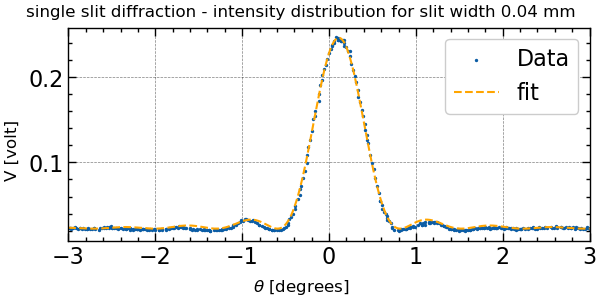

In [10]:
pcov, popt = fit_and_plot_diffraction_pattern(dir, [files[1]], 
                                 [[[0.02*mm, 600*nm, 0, 0.001, 0],[0.05*mm, 650*nm, 4, np.deg2rad(1), 1]]], 
                                 single_slit, (6,3), 
                                 'single slit diffraction - intensity distribution for slit width',
                                 ['slit width', 'lambda', 'I0', 'alpha' ,'c'],
                                 (-3, 3))

0.02
slit width - 2.7027255000789192e-05 +- 7.592553487531915e-13
lambda - 6.180680716492324e-07 +- 4.0023771618902627e-16
I0 - 2.918435455191097 +- 7.066715247967276e-05
alpha - 0.004904716394413058 +- 8.439758476592168e-10
c - 0.030627443828179116 +- 2.7086330783018683e-06
0.9913658224911335


0.04
slit width - 5.106891814597016e-05 +- 1.0869006576064907e-12
lambda - 6.294098160355962e-07 +- 1.6601396504962464e-16
I0 - 0.22336507827552776 +- 2.1306781065191048e-07
alpha - 0.0019610789330821166 +- 1.409959504493236e-10
c - 0.022418321315133622 +- 5.519218678668148e-09
0.9963325756279316


0.08
slit width - 8.283999684267581e-05 +- 1.2360622624937876e-11
lambda - 6.391349707690372e-07 +- 7.484040826070072e-16
I0 - 1.5900909898593654 +- 0.0001121328571551354
alpha - 0.006019765298001052 +- 5.089805936924567e-10
c - 0.029418195454276538 +- 8.141833494864108e-07
0.9845443209707424


0.16
slit width - 0.0001778587966830668 +- 8.768266639557527e-11
lambda - 6.10653337050774e-07 +- 1.0523777

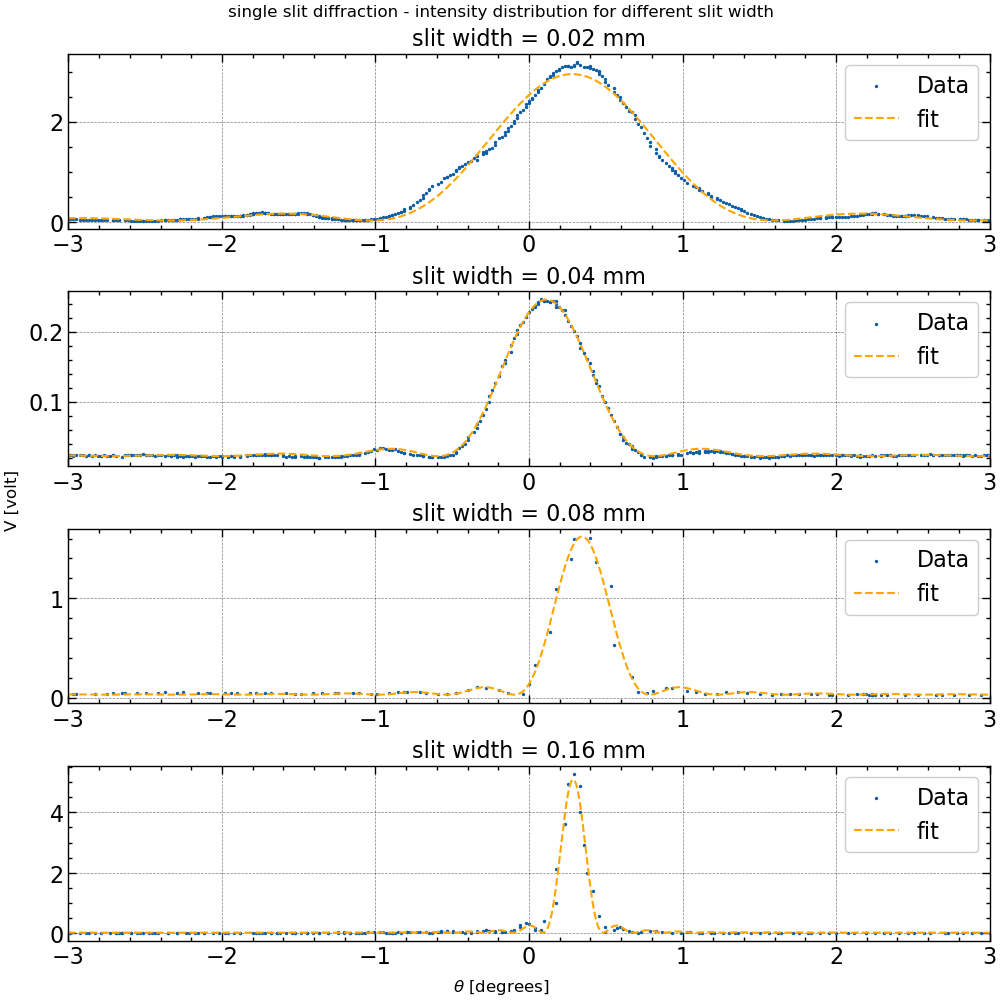

In [11]:
pcov, popt = fit_and_plot_diffraction_pattern(dir, files, 
                                 [[[0.02*mm, 600*nm, 0, 0.001, 0],[0.18*mm, 650*nm, 8, np.deg2rad(1), 1]] for i in range(4)], 
                                 single_slit, (10,10), 
                                 'single slit diffraction - intensity distribution for different slit width',
                                 ['slit width', 'lambda', 'I0', 'alpha' ,'c'], 
                                 (-3,3))

### Double slits

In [226]:
dir = 'Data\\two slits\\new\\'
files = ['0.04 mm - space 0.25 mm.txt', 
         '0.08 mm - space 0.25 mm.txt', 
         '0.04 mm - space 0.5 mm.txt', 
         '0.08 mm - space 0.5 mm.txt']
ANGLE = 'Ch1[V]'
VOLT = 'Ch0[V]'

In [186]:
def double_slit(theta, I0, lamda, gamma, slit_width, slit_space, c):
    alpha = (slit_space*mm * (np.pi / lamda) * np.sin(np.deg2rad(theta) - gamma))
    beta = (slit_width*mm * (np.pi / lamda) * np.sin(np.deg2rad(theta) - gamma))
    return I0 * (np.sin(beta)/beta)**2 * np.cos(alpha)**2 + c

0.04
I0 - 4.9469846348694695 +- 0.004012504637040339
lamda - 6.356823030510048e-07 +- 1.8338959543056076e-17
gamma - 0.006308139214353757 +- 4.669092527419349e-11
slit_width - 0.04952424906036789 +- 5.76307222865811e-07
slit_space - 0.2586796286688902 +- 2.7661033306985604e-06
c - 0.053572128786023236 +- 6.0735334443450256e-05
0.762252827873187




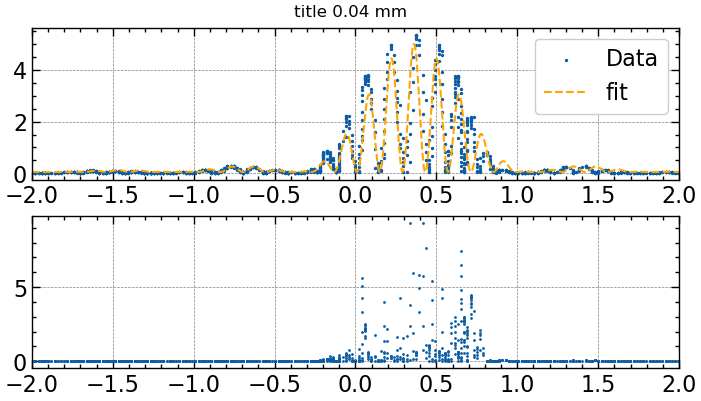

In [187]:
popt, pcov = fit_and_plot_diffraction_pattern_and_residuals(dir, [files[0]], 
                                [[[0, 600*nm, np.deg2rad(0.1), 0.02, 0.2, 0], [6, 650*nm, np.deg2rad(0.6), 0.05, 0.3, 1]]], 
                                double_slit,
                                (7,4), 
                                'title',
                                ['I0', 'lamda', 'gamma', 'slit_width', 'slit_space', 'c'],
                                x_lim=(-2, 2))

0.04
I0 - 5.040174888606339 +- 0.004087596321788325
lamda - 6.33987161305226e-07 +- 1.972915219856887e-17
gamma - 0.0063099825631390515 +- 4.642872386062591e-11
slit_width - 0.05058320512657424 +- 4.006660183223913e-07
slit_space - 0.25717274933492623 +- 3.327920640683e-06
c - 0.055949200010389395 +- 6.05256526762919e-05
0.7627367240215781


0.08
I0 - 9.045352761699057 +- 0.005932323413338689
lamda - 6.302420453512114e-07 +- 1.3637667848812263e-16
gamma - 0.006849223217981875 +- 1.7071636253244747e-11
slit_width - 0.10990715369113799 +- 4.314571749649843e-06
slit_space - 0.2959900598825042 +- 3.067418989294555e-05
c - 0.05929108639440526 +- 0.00011880311284786294
0.8995962289000313




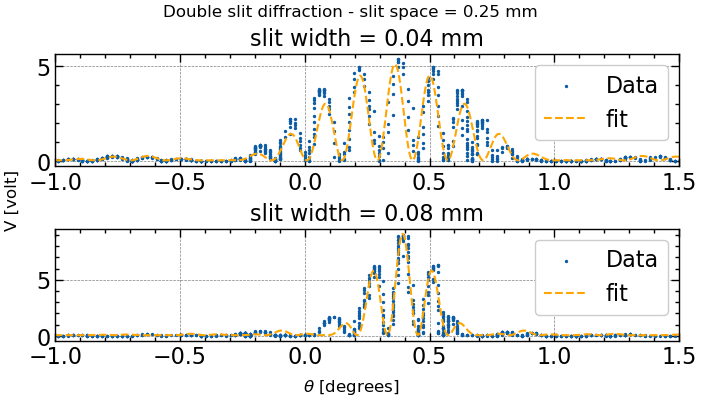

In [188]:
popt, pcov = fit_and_plot_diffraction_pattern(dir, files[:2], 
                                [[[0, 600*nm, np.deg2rad(0.2), 0.04, 0.23, 0], [10, 650*nm, np.deg2rad(0.55), 0.11, 0.31, 1]] for i in range(2)], 
                                double_slit,
                                (7,4), 
                                'Double slit diffraction - slit space = 0.25 mm',
                                ['I0', 'lamda', 'gamma', 'slit_width', 'slit_space', 'c'],
                                x_lim=(-1,1.5))


0.04
I0 - 1.801268913987973 +- 0.0008540719194432341
lamda - 6.324681894837363e-07 +- 4.118646701005039e-18
gamma - 0.005661253429835388 +- 2.2404040814040174e-11
slit_width - 0.04199764056844448 +- 5.874303236100465e-07
slit_space - 0.5012497030492729 +- 2.369137106096465e-06
c - 0.01494200342081577 +- 2.6555053315349178e-05
0.36509587565039825


0.08
I0 - 8.436616957385874 +- 0.007801584574250727
lamda - 6.296534296271422e-07 +- 9.109127893482356e-18
gamma - 0.006037888992614575 +- 8.484809722787343e-12
slit_width - 0.08615623375792411 +- 1.098456575407928e-06
slit_space - 0.5266744670763489 +- 5.998192466640272e-06
c - 0.05343477180275662 +- 6.379079435697359e-05
0.8312406761883252




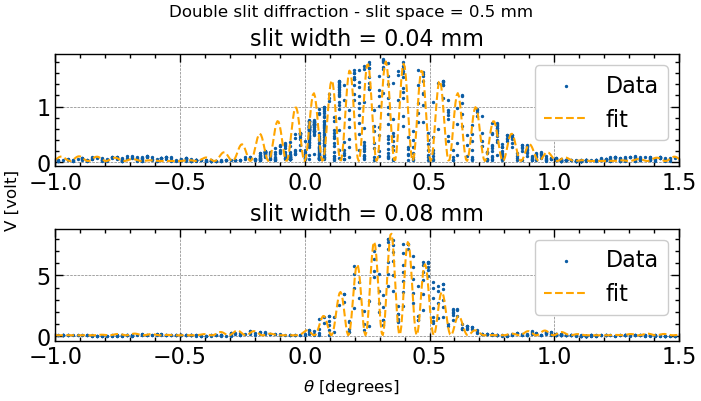

In [230]:
popt, pcov = fit_and_plot_diffraction_pattern(dir, files[2:], 
                                [[[1.8, 600*nm, np.deg2rad(0.1), 0.039, 0.48, 0], [4, 650*nm, np.deg2rad(0.55), 0.042, 0.52, 1]],
                                 [[0, 600*nm, np.deg2rad(0.2), 0.075, 0.4, 0], [10, 650*nm, np.deg2rad(0.55), 0.09, 0.6, 1]]], 
                                double_slit,
                                (7,4), 
                                'Double slit diffraction - slit space = 0.5 mm',
                                ['I0', 'lamda', 'gamma', 'slit_width', 'slit_space', 'c'],
                                x_lim=(-1,1.5))

0.04
I0 - 1.801268913987973 +- 0.0008540719194432341
lamda - 6.324681894837363e-07 +- 4.118646701005039e-18
gamma - 0.005661253429835388 +- 2.2404040814040174e-11
slit_width - 0.04199764056844448 +- 5.874303236100465e-07
slit_space - 0.5012497030492729 +- 2.369137106096465e-06
c - 0.01494200342081577 +- 2.6555053315349178e-05
0.36509587565039825




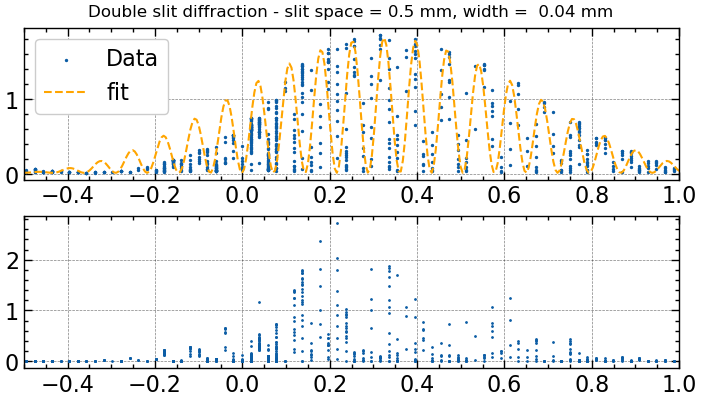

In [233]:
popt, pcov = fit_and_plot_diffraction_pattern_and_residuals(dir, [files[2]], 
                                [[[1.8, 600*nm, np.deg2rad(0.1), 0.039, 0.48, 0], [4, 650*nm, np.deg2rad(0.55), 0.042, 0.52, 1]]], 
                                double_slit,
                                (7,4), 
                                'Double slit diffraction - slit space = 0.5 mm, width = ',
                                ['I0', 'lamda', 'gamma', 'slit_width', 'slit_space', 'c'],
                                x_lim=(-0.5,1))

### N slits

In [7]:
def fit_and_plot_n_slits(dir, files_array, bound, fit_func, fig_size, 
                                                   title, param_string, x_lim = None):
    data_array = get_data(dir, files_array)
    fig, ax = plt.subplots(nrows=2, ncols=1, layout='constrained', 
                           figsize = fig_size)
    data,width = data_array[0]
    # data = data[(data[ANGLE] > -0.5) & (data[ANGLE] < 0.5)]

    fig.suptitle(f"{title} {width} mm")
    ax[0].scatter(data[ANGLE], data[VOLT],  s=2, label='Data')
    # fit
    theta_fit = np.linspace(x_lim[0],x_lim[1], n_fit)
    popt, pcov = curve_fit(fit_func, data[ANGLE], data[VOLT], bounds=bound[0], maxfev=5000)
    v_fit = fit_func(theta_fit, *popt)

    print_parameters(popt, pcov, width, param_string)
    print(fit_r_squared(fit_func, data[ANGLE], data[VOLT], popt))
    print("\n")

    ax[0].plot(theta_fit, v_fit, color='orange', linestyle='dashed', linewidth = 1.5, label='fit')
    if x_lim:
        ax[0].set_xlim(x_lim[0], x_lim[1])
    ax[0].legend()

    #plot residuals
    ax[1].scatter(data[ANGLE], (data[VOLT]-fit_func(data[ANGLE], *popt))**2, s=1, label='residuals')
    if x_lim:
        ax[1].set_xlim(x_lim[0], x_lim[1])
    return popt, pcov

In [8]:
def n_slits(theta, slit_width, lamda, I0, gamma, N):
    alpha = (0.125*mm * (np.pi / lamda)) * np.sin(np.deg2rad(theta) - gamma)
    beta = (slit_width*mm * (np.pi / lamda)) * np.sin(np.deg2rad(theta) - gamma)
    return I0 * (np.sin(beta)/beta)**2 * (np.sin(N*alpha)/np.sin(alpha))**2

In [9]:
dir = 'Data\\n slits\\'
files = ['n slits 8 lines per mm.txt', 
         'n slits 8 lines per mm - 2.txt']
ANGLE = 'Ch1[V]'
VOLT = 'Ch0[V]'

In [ ]:
fit_and_plot_n_slits(dir, [files[0]], 
                      [[[0.01, 630*nm,0.01, -0.003, 3], 
                        [0.031, 670*nm,0.4, -0.002, 7]]],
                      n_slits,
                      (5,5),  
                      '8 slits per mm diffraction pattern',
                      ['slit_width','lamda' ,'I0', 'gamma', 'N'], 
                      x_lim=(-3,3))

      Index  Time[s]    Ch0[V]    Ch1[V]
1807   1807    180.7  0.641758 -1.939086
1840   1840    184.0  1.002482 -1.642438
1883   1883    188.3  0.789912 -1.326014
1934   1934    193.4  1.110699 -0.989814
1985   1985    198.5  3.358786 -0.673390
2062   2062    206.2  6.716099 -0.337189
2130   2130    213.0  8.526163 -0.020765
2191   2191    219.1  7.358962  0.295659
2230   2230    223.0  3.993918  0.572530
2287   2287    228.7  1.341305  0.829624
2314   2314    231.4  0.690713  1.106495
2354   2354    235.4  0.874940  1.403143
2383   2383    238.3  0.662370  1.719567
lamda from each maxima:
[6.90326588140074e-07, 6.903265881400772e-07, 6.471729005174867e-07, 7.11887518917757e-07, 6.183980072863868e-07, 7.046783773291345e-07, 6.147855789781505e-07, 7.118413384643394e-07, 6.212331356621596e-07, 7.074938798150296e-07, 6.32705288464272e-07, 6.973907254553738e-07]

mean lamda from distance between peaks = 6.7068666059752e-07 +- 3.839070403896128e-08


(-4.0, 4.0)

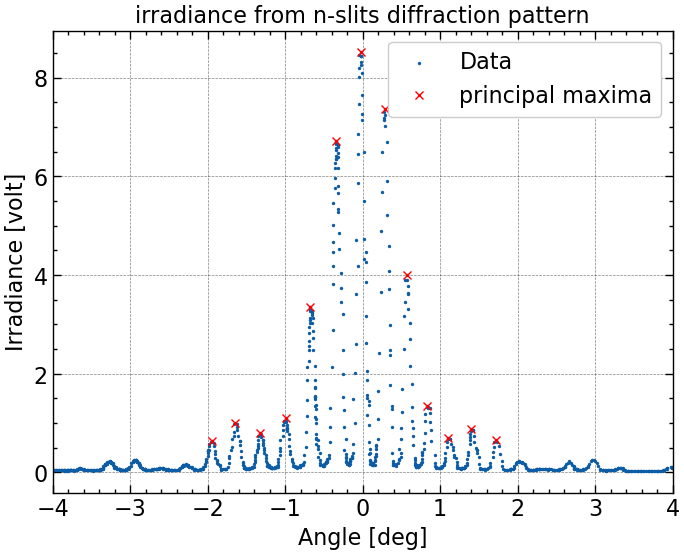

In [10]:
data_array = get_data(dir, [files[0]])
data,width = data_array[0]
plt.figure()

plt.scatter(data[ANGLE], data[VOLT],  s=2, label='Data')

peaks, properties = find_peaks(data[VOLT],prominence=(0.3))
peaks_angle = data.iloc[peaks.tolist()]
print(peaks_angle)
max_peak = data[ANGLE][2130]
lamdas = []
a=0.125*mm
for i in range(1,7):
    lamdas.append(a*np.sin(np.deg2rad(data[ANGLE][peaks[6+i]]-max_peak))/i)
    lamdas.append(a*np.sin(np.deg2rad(data[ANGLE][peaks[6-i]]-max_peak))/(-i))
avg_lamda = np.mean(np.asarray(lamdas))
std_lamda = np.std(np.asarray(lamdas))
print("lamda from each maxima:")
print(lamdas)
print(f"\nmean lamda from distance between peaks = {avg_lamda} +- {std_lamda}")
# print(f"{avg_dist*b/np.pi}")
plt.plot(data[ANGLE][peaks], data[VOLT][peaks], 'xr', label='principal maxima')

# b = 0.028
# lam = 650 * nm
# I0 = 0.33
# gamma = -0.0020
# N = 5
# x = np.linspace(-10, 10, 2000)
# plt.plot(x, n_slits(x, b, lam, I0, gamma, N), color='orange', linewidth=1)

plt.title("irradiance from n-slits diffraction pattern")
plt.legend()
plt.xlabel('Angle [deg]')
plt.ylabel('Irradiance [volt]')
plt.xlim(-4,4)

      Index  Time[s]    Ch0[V]    Ch1[V]
1062   1062    106.2  0.286186 -1.306238
1110   1110    111.0  0.451089 -1.009590
1147   1147    114.7  0.345448 -0.712943
1191   1191    119.1  0.615992 -0.436072
1226   1226    122.6  1.982880 -0.198754
1260   1260    126.0  4.018396  0.058341
1308   1308    130.8  5.095416  0.295659
1345   1345    134.5  4.187163  0.552753
1377   1377    137.7  2.196738  0.849401
1406   1406    140.6  0.729362  1.146048
1440   1440    144.0  0.449801  1.422919
1475   1475    147.5  0.627586  1.699790
1511   1511    151.1  0.463972  1.976661
lamda from each maxima:
[5.608913218123344e-07, 5.177460925347749e-07, 6.040294317832561e-07, 5.393136953814879e-07, 6.183980072863878e-07, 5.321149849350505e-07, 6.147855789781505e-07, 5.500783854855558e-07, 6.126066372177058e-07, 5.694730707714708e-07, 6.111420884703121e-07, 5.823901397902393e-07]

mean lamda from distance between peaks = 5.760807862038937e-07 +- 3.453431787635462e-08


(-4.0, 4.0)

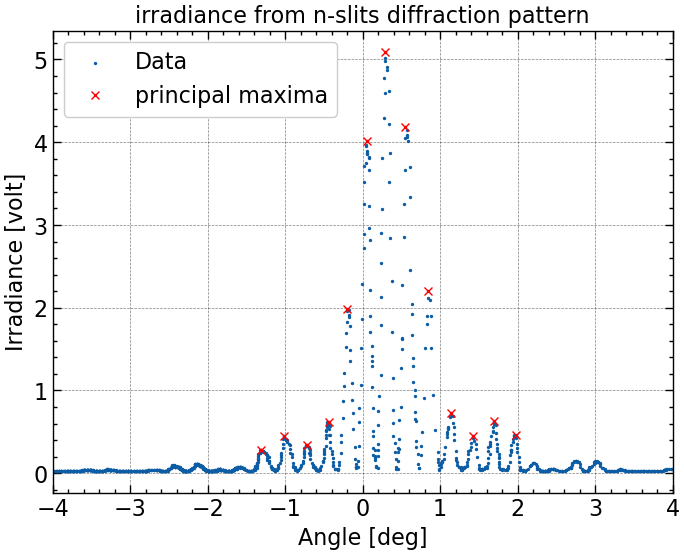

In [10]:
data_array = get_data(dir, [files[1]])
data,width = data_array[0]
plt.figure()

plt.scatter(data[ANGLE], data[VOLT],  s=2, label='Data')

peaks, properties = find_peaks(data[VOLT],prominence=(0.2))
peaks_angle = data.iloc[peaks.tolist()]
print(peaks_angle)
max_peak = data[ANGLE][1308]
lamdas = []
a=0.125*mm
for i in range(1,7):
    lamdas.append(a*np.sin(np.deg2rad(data[ANGLE][peaks[6+i]]-max_peak))/i)
    lamdas.append(a*np.sin(np.deg2rad(data[ANGLE][peaks[6-i]]-max_peak))/(-i))
avg_lamda = np.mean(np.asarray(lamdas))
std_lamda = np.std(np.asarray(lamdas))
print("lamda from each maxima:")
print(lamdas)
print(f"\nmean lamda from distance between peaks = {avg_lamda} +- {std_lamda}")
plt.plot(data[ANGLE][peaks], data[VOLT][peaks], 'xr', label='principal maxima')

# b = 0.028
# lam = 650 * nm
# I0 = 0.33
# gamma = -0.0020
# N = 5
# x = np.linspace(-10, 10, 2000)
# plt.plot(x, n_slits(x, b, lam, I0, gamma, N), color='orange', linewidth=1)

plt.title("irradiance from n-slits diffraction pattern")
plt.legend()
plt.xlabel('Angle [deg]')
plt.ylabel('Irradiance [volt]')
plt.xlim(-4,4)

In [12]:
lamda_all = np.array([576*nm, 670*nm, 
                      633.9*nm, 630.2*nm, 632.5*nm, 629.6*nm, 
                      618*nm, 629*nm, 639.1*nm, 610*nm])
print(f"total lamda mean = {np.mean(lamda_all)} +- {np.std(lamda_all)}")


total lamda mean = 6.268300000000001e-07 +- 2.250551265801336e-08


In [15]:
N_sigma = np.abs(632.8*nm - np.mean(lamda_all)) / np.std(lamda_all)
print(f"n sigma = {N_sigma}")

n sigma = 0.26526834072692185
